# Facial Expression Recognition
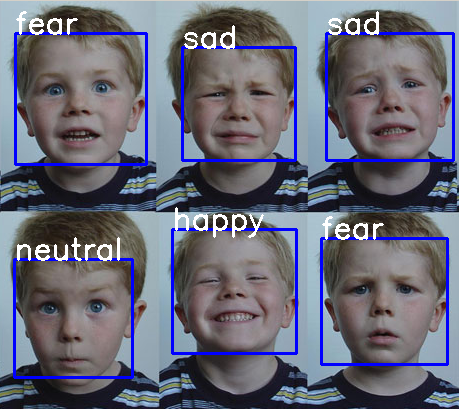

This notebook deals with an image classification problem,to identify an expression of human face using a custom model and pre-trained model(transfer-learing) .The models used are ResNets.

# Downloading required libraries 
## Data extraction and understanding data using EDA

In [ ]:
import os
import numpy as np
import torch
import torchvision
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

%matplotlib inline


matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bandarisaidrupadh
Your Kaggle Key: ··········


100%|██████████| 121M/121M [00:06<00:00, 20.6MB/s]


In [ ]:
Train_dir = './face-expression-recognition-dataset/images/train'
train_classes = os.listdir(Train_dir)
print(train_classes)

['sad', 'neutral', 'happy', 'fear', 'disgust', 'surprise', 'angry']


In [ ]:
Val_dir = './face-expression-recognition-dataset/images/validation'
Val_classes = os.listdir(Val_dir)
print(Val_classes)

['sad', 'neutral', 'happy', 'fear', 'disgust', 'surprise', 'angry']


In [ ]:
num_classes = len(train_classes)

In [ ]:
stats=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_tfms = tt.Compose([tt.RandomCrop(48, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_dataset = ImageFolder(Train_dir,train_tfms)
val_dataset = ImageFolder(Val_dir, valid_tfms)

In [ ]:
dataset_size = len(train_dataset)

In [ ]:
classes = list(train_dataset.classes)

In [ ]:
image, label = train_dataset[0]
print('image_shape:', image.shape, 'Label:',label)

image_shape: torch.Size([3, 48, 48]) Label: 0


In [ ]:
image, label = val_dataset[0]
print('image_shape:', image.shape, 'Label:',label)

image_shape: torch.Size([3, 48, 48]) Label: 0


In [ ]:
image_class_count = {}
for i in range(num_classes):
    image_class_count[classes[i]] = 0

for i in range(dataset_size):
    image, label = train_dataset[i]
    image_class_count[classes[label]] += 1

image_class_count

{'angry': 3993,
 'disgust': 436,
 'fear': 4103,
 'happy': 7164,
 'neutral': 4982,
 'sad': 4938,
 'surprise': 3205}

In [ ]:
import pandas as pd

In [ ]:
Image_class_count = pd.DataFrame(image_class_count.items(), columns=['category','count'])
Image_class_count

,category,count
0,angry,3993
1,disgust,436
2,fear,4103
3,happy,7164
4,neutral,4982
5,sad,4938
6,surprise,3205


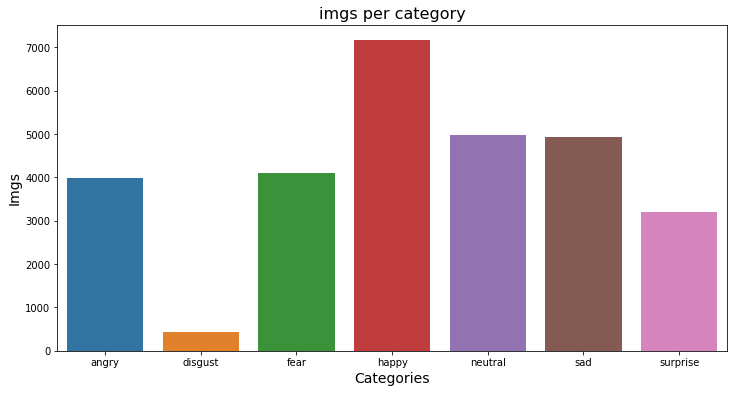

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data = Image_class_count, x='category', y='count')
plt.title('imgs per category', size=16)
plt.ylabel('Imgs', size=14)
plt.xlabel('Categories', size=14)
plt.show;

Seems like no of images in class disgust are very low,so while performing dataloader operation we use torchsampler library and ImbalancedDatasetSampler function

In [ ]:
batch_size = 300
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
!pip install torchsampler --upgrade --quite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchsampler import ImbalancedDatasetSampler

In [ ]:
Mod_train_dl = DataLoader(train_dataset, batch_size, num_workers=2, shuffle=False, sampler=ImbalancedDatasetSampler(train_dataset),pin_memory = True)

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

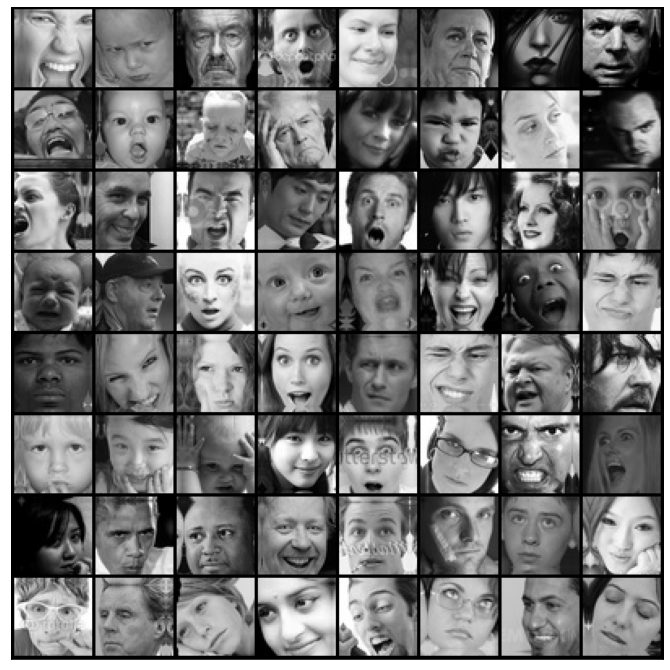

In [ ]:
show_batch(train_dl)

# Using GPU runtime

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
Mod_train_dl =DeviceDataLoader(Mod_train_dl, device)


#Creating required helper-classes,functions and models

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.3),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model= to_device(ResNet9(3,10),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
from torchvision import models

class Transfer_CNN(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

#Image classification using created models

In [ ]:
model1 = Transfer_CNN(num_classes)
to_device(model1,device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Transfer_CNN(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

Using ResNet9 algorithm model,data is trained and validated,ResNet helps to prevent vanishing gradients i.e if model is too deep it loses its ability to update the weights using gradient descent

> The hyperparameters used are:
*   Scheduled learning rate
*   Weight decay
*   Gradient clipping

> 


Scheduled learning rate limits the overfitting by controlling the weights updatation.

Weight decay increases the loss value then the actual,so overall loss increases,efforts to minimize loss by model increases.

Gradient clipping controls the exploding gradients similar to vanishing gradients but in opposite way.











In [ ]:
h1= fit_one_cycle(10,0.01,model,train_dl,valid_dl,weight_decay=1e-3,grad_clip=0.1,opt_func=torch.optim.Adam)

Epoch [0], last_lr: 0.00277, train_loss: 1.9425, val_loss: 1.6476, val_acc: 0.3601
Epoch [1], last_lr: 0.00758, train_loss: 1.5169, val_loss: 1.7346, val_acc: 0.2912
Epoch [2], last_lr: 0.01000, train_loss: 1.4225, val_loss: 1.5302, val_acc: 0.3958
Epoch [3], last_lr: 0.00950, train_loss: 1.3127, val_loss: 1.8022, val_acc: 0.2981
Epoch [4], last_lr: 0.00812, train_loss: 1.2660, val_loss: 1.5129, val_acc: 0.4221
Epoch [5], last_lr: 0.00611, train_loss: 1.2154, val_loss: 1.2740, val_acc: 0.5215
Epoch [6], last_lr: 0.00389, train_loss: 1.1614, val_loss: 1.3358, val_acc: 0.5175
Epoch [7], last_lr: 0.00188, train_loss: 1.0820, val_loss: 1.0809, val_acc: 0.5813
Epoch [8], last_lr: 0.00050, train_loss: 0.9995, val_loss: 0.9782, val_acc: 0.6387
Epoch [9], last_lr: 0.00000, train_loss: 0.9293, val_loss: 0.9502, val_acc: 0.6481



*   Lr = 0.01
*   Wd = 1e-3
*   Grad_Clip = 0.1
*   Wd adds 0.001 times the square of weights to loss value in each iteration and gradient is clipped to 0.1 for each gradient update.




In [ ]:
h1+= fit_one_cycle(10,0.01,model,train_dl,valid_dl,weight_decay=1e-4,grad_clip=0.2,opt_func=torch.optim.Adam)

Epoch [0], last_lr: 0.00277, train_loss: 0.9431, val_loss: 1.4342, val_acc: 0.4758
Epoch [1], last_lr: 0.00758, train_loss: 1.0551, val_loss: 1.6879, val_acc: 0.4172
Epoch [2], last_lr: 0.01000, train_loss: 1.1016, val_loss: 1.6806, val_acc: 0.4178
Epoch [3], last_lr: 0.00950, train_loss: 1.0758, val_loss: 1.2422, val_acc: 0.5174
Epoch [4], last_lr: 0.00812, train_loss: 1.0422, val_loss: 1.4328, val_acc: 0.4829
Epoch [5], last_lr: 0.00611, train_loss: 1.0078, val_loss: 1.0404, val_acc: 0.6152
Epoch [6], last_lr: 0.00389, train_loss: 0.9472, val_loss: 0.9731, val_acc: 0.6406
Epoch [7], last_lr: 0.00188, train_loss: 0.9073, val_loss: 0.9355, val_acc: 0.6595
Epoch [8], last_lr: 0.00050, train_loss: 0.8434, val_loss: 0.9094, val_acc: 0.6704
Epoch [9], last_lr: 0.00000, train_loss: 0.8062, val_loss: 0.9069, val_acc: 0.6687



*   Lr = 0.01
*   Wd = 1e-4
*   Grad_Clip = 0.2




Wd adds 0.0001 times the square of weights to loss value in each iteration and gradient is clipped to 0.2 for each gradient update.This means additional amount of loss is added to actual loss and gradients can go upto 0.2 this results in greater update of weights for greater loss there by reducing overall loss without overfitting








In [ ]:
h1+= fit_one_cycle(5,0.004,model,train_dl,valid_dl,weight_decay=1e-4,grad_clip=0.1,opt_func=torch.optim.Adam)

Epoch [0], last_lr: 0.00303, train_loss: 0.8166, val_loss: 1.3500, val_acc: 0.5324
Epoch [1], last_lr: 0.00380, train_loss: 0.8891, val_loss: 1.0417, val_acc: 0.6173
Epoch [2], last_lr: 0.00245, train_loss: 0.8827, val_loss: 0.9589, val_acc: 0.6542
Epoch [3], last_lr: 0.00075, train_loss: 0.8228, val_loss: 0.9030, val_acc: 0.6714
Epoch [4], last_lr: 0.00000, train_loss: 0.7576, val_loss: 0.8964, val_acc: 0.6771


In [ ]:
h1+= fit_one_cycle(5,0.004,model,train_dl,valid_dl,weight_decay=1e-3,grad_clip=0.1,opt_func=torch.optim.Adam)

Epoch [0], last_lr: 0.00303, train_loss: 0.7706, val_loss: 1.2537, val_acc: 0.5182
Epoch [1], last_lr: 0.00380, train_loss: 0.9002, val_loss: 1.1359, val_acc: 0.5639
Epoch [2], last_lr: 0.00245, train_loss: 0.9235, val_loss: 0.9658, val_acc: 0.6401
Epoch [3], last_lr: 0.00075, train_loss: 0.8729, val_loss: 0.9294, val_acc: 0.6590
Epoch [4], last_lr: 0.00000, train_loss: 0.7994, val_loss: 0.9049, val_acc: 0.6726



*   Lr = 0.004
*   Wd = 1e-3
*   Grad_Clip = 0.1




Wd adds 0.001 times the square of weights to loss value in each iteration and gradient is clipped to 0.1 for each gradient update.This means additional amount of loss is added to actual loss and gradients can go upto 0.1.








In [ ]:
model2= to_device(ResNet9(3,10),device)
model2

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
h2 = fit_one_cycle(15,0.01,model2,Mod_train_dl,valid_dl,weight_decay=1e-3,grad_clip=0.1,opt_func=torch.optim.Adam)

Epoch [0], last_lr: 0.00151, train_loss: 2.0287, val_loss: 1.7512, val_acc: 0.3270
Epoch [1], last_lr: 0.00435, train_loss: 1.5904, val_loss: 1.6065, val_acc: 0.3662
Epoch [2], last_lr: 0.00759, train_loss: 1.4139, val_loss: 1.6677, val_acc: 0.3458
Epoch [3], last_lr: 0.00971, train_loss: 1.3775, val_loss: 1.9482, val_acc: 0.2205
Epoch [4], last_lr: 0.00994, train_loss: 1.3188, val_loss: 1.8917, val_acc: 0.3181
Epoch [5], last_lr: 0.00950, train_loss: 1.2785, val_loss: 4.4906, val_acc: 0.0978
Epoch [6], last_lr: 0.00867, train_loss: 1.2365, val_loss: 1.9284, val_acc: 0.3145
Epoch [7], last_lr: 0.00750, train_loss: 1.1911, val_loss: 1.5048, val_acc: 0.4300
Epoch [8], last_lr: 0.00611, train_loss: 1.1424, val_loss: 1.2870, val_acc: 0.5082
Epoch [9], last_lr: 0.00463, train_loss: 1.1158, val_loss: 1.3408, val_acc: 0.5165
Epoch [10], last_lr: 0.00317, train_loss: 1.0401, val_loss: 1.2092, val_acc: 0.5490
Epoch [11], last_lr: 0.00188, train_loss: 0.9680, val_loss: 1.0521, val_acc: 0.6041
Ep

In [ ]:
h2 += fit_one_cycle(10,0.004,model2,Mod_train_dl,valid_dl,weight_decay=1e-4,grad_clip=0.1,opt_func=torch.optim.Adam)

Epoch [0], last_lr: 0.00111, train_loss: 0.7835, val_loss: 0.9732, val_acc: 0.6403
Epoch [1], last_lr: 0.00303, train_loss: 0.8406, val_loss: 1.2053, val_acc: 0.5461
Epoch [2], last_lr: 0.00400, train_loss: 0.8999, val_loss: 1.5270, val_acc: 0.5039
Epoch [3], last_lr: 0.00380, train_loss: 0.9031, val_loss: 1.2087, val_acc: 0.5828
Epoch [4], last_lr: 0.00325, train_loss: 0.8465, val_loss: 1.0155, val_acc: 0.6285
Epoch [5], last_lr: 0.00245, train_loss: 0.8196, val_loss: 1.0360, val_acc: 0.6294
Epoch [6], last_lr: 0.00155, train_loss: 0.7723, val_loss: 0.9641, val_acc: 0.6499
Epoch [7], last_lr: 0.00075, train_loss: 0.7240, val_loss: 0.9366, val_acc: 0.6618
Epoch [8], last_lr: 0.00020, train_loss: 0.6877, val_loss: 0.9246, val_acc: 0.6682
Epoch [9], last_lr: 0.00000, train_loss: 0.6662, val_loss: 0.9245, val_acc: 0.6659


In [ ]:
h3 = fit_one_cycle(10,0.01,model1,train_dl,valid_dl,weight_decay=1e-3,grad_clip=0.1,opt_func=torch.optim.Adam)

Epoch [0], last_lr: 0.00277, train_loss: 1.2377, val_loss: 1.3898, val_acc: 0.4850
Epoch [1], last_lr: 0.00758, train_loss: 1.2877, val_loss: 2.5300, val_acc: 0.2758
Epoch [2], last_lr: 0.01000, train_loss: 1.3505, val_loss: 2.0156, val_acc: 0.3304
Epoch [3], last_lr: 0.00950, train_loss: 1.3591, val_loss: 1.8413, val_acc: 0.3746
Epoch [4], last_lr: 0.00812, train_loss: 1.3136, val_loss: 1.8121, val_acc: 0.3174
Epoch [5], last_lr: 0.00611, train_loss: 1.2660, val_loss: 1.4342, val_acc: 0.4533
Epoch [6], last_lr: 0.00389, train_loss: 1.2397, val_loss: 1.2492, val_acc: 0.5323
Epoch [7], last_lr: 0.00188, train_loss: 1.1791, val_loss: 1.1560, val_acc: 0.5664
Epoch [8], last_lr: 0.00050, train_loss: 1.1255, val_loss: 1.1061, val_acc: 0.5869
Epoch [9], last_lr: 0.00000, train_loss: 1.0808, val_loss: 1.0918, val_acc: 0.5926


In [ ]:
h3 += fit_one_cycle(10,0.004,model1,train_dl,valid_dl,weight_decay=1e-4,grad_clip=0.1,opt_func=torch.optim.Adam)

Epoch [0], last_lr: 0.00111, train_loss: 1.0739, val_loss: 1.0992, val_acc: 0.5895
Epoch [1], last_lr: 0.00303, train_loss: 1.0977, val_loss: 1.2523, val_acc: 0.5330
Epoch [2], last_lr: 0.00400, train_loss: 1.1354, val_loss: 1.3125, val_acc: 0.5188
Epoch [3], last_lr: 0.00380, train_loss: 1.1242, val_loss: 1.1985, val_acc: 0.5537
Epoch [4], last_lr: 0.00325, train_loss: 1.0945, val_loss: 1.2164, val_acc: 0.5405
Epoch [5], last_lr: 0.00245, train_loss: 1.0798, val_loss: 1.1117, val_acc: 0.5831
Epoch [6], last_lr: 0.00155, train_loss: 1.0499, val_loss: 1.0920, val_acc: 0.5921
Epoch [7], last_lr: 0.00075, train_loss: 1.0175, val_loss: 1.0509, val_acc: 0.6112
Epoch [8], last_lr: 0.00020, train_loss: 0.9858, val_loss: 1.0354, val_acc: 0.6159
Epoch [9], last_lr: 0.00000, train_loss: 0.9724, val_loss: 1.0347, val_acc: 0.6170


In [ ]:
h3 += fit_one_cycle(5,0.004,model1,train_dl,valid_dl,weight_decay=1e-3,grad_clip=0.1,opt_func=torch.optim.Adam)

Epoch [0], last_lr: 0.00303, train_loss: 0.9904, val_loss: 1.2053, val_acc: 0.5518
Epoch [1], last_lr: 0.00380, train_loss: 1.0701, val_loss: 1.3662, val_acc: 0.5111
Epoch [2], last_lr: 0.00245, train_loss: 1.0753, val_loss: 1.1211, val_acc: 0.5786
Epoch [3], last_lr: 0.00075, train_loss: 1.0390, val_loss: 1.0432, val_acc: 0.6166
Epoch [4], last_lr: 0.00000, train_loss: 0.9816, val_loss: 1.0325, val_acc: 0.6232


#Accuracy and loss plots for different models

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

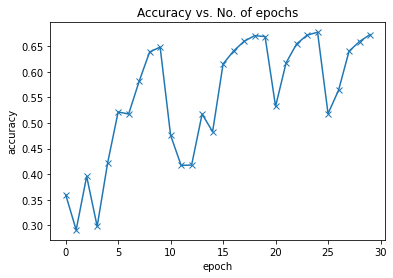

In [ ]:
plot_accuracies(h1)

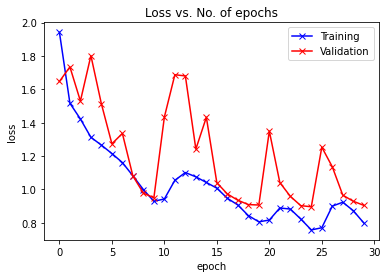

In [ ]:
plot_losses(h1)

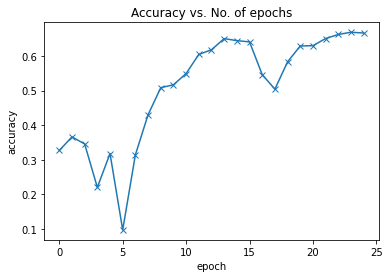

In [ ]:
plot_accuracies(h2)

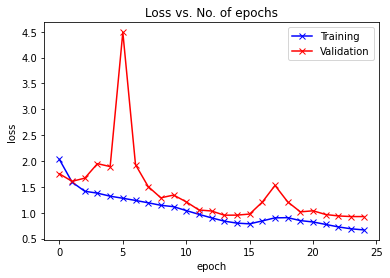

In [ ]:
plot_losses(h2)

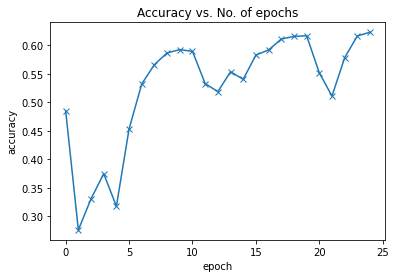

In [ ]:
plot_accuracies(h3)

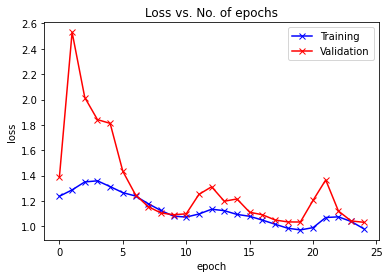

In [ ]:
plot_losses(h3)

Variation in input dataset (by using Imbalanced Dataset Sampler) has little to no effect on the validation accuarcy.


> The models used are:
*   ResNet9
*   ResNet9(with Imbalanced Dataset Sampler)
*   ResNet34 (with modified final layer)








#Predicition from trained models

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

Using same input for different models to analyse predictions.





Label: angry , Predicted: angry


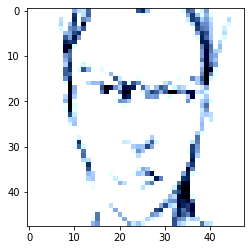

In [ ]:
img, label = val_dataset[10]
plt.imshow(img.permute(1, 2, 0))
print('Label:', val_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: angry , Predicted: angry


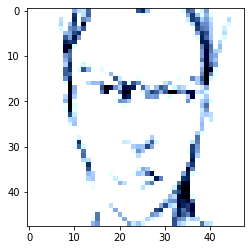

In [ ]:
img, label = val_dataset[10]
plt.imshow(img.permute(1, 2, 0))
print('Label:', val_dataset.classes[label], ', Predicted:', predict_image(img, model2))

Label: angry , Predicted: angry


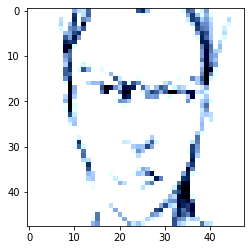

In [ ]:
img, label = val_dataset[10]
plt.imshow(img.permute(1, 2, 0))
print('Label:', val_dataset.classes[label], ', Predicted:', predict_image(img, model1))

# Conclusion
Two models ResNet9 and Resnet34 are used with different hyperparameters is used for Facial expression recognition (image classification problem).It is observed that different models tanked at an accuracy of 63-67%.

> The accuracy hence can be improved by increasing size of dataset and the quality of dataset and little more finetuning of hyperparameters.




#  Future work
Collecting more elements for individual class,especially for disgust class and if observed carefully, the dataset is a grey scale image but tensor shows RGB channels.So creating polished and improved dataset can make this dataset more predictable.This can be a some futurework and finetuning more hyperparameters and custom models can be helpful.

# References


1.   https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
2.   https://www.kaggle.com/code/ngdaghuynh/face-expression-recognition
3.   https://www.kaggle.com/code/doanquanvietnamca/imbalanced-dataset-sampler
4. https://jovian.ai/jolleyrancher2/zero-to-gans-course-project2






